In [2]:
import serial
import time

data = []

# Setup serial connection
# Adjust '/dev/ttyACM0' or 'COM7' to the serial port your Pico is connected to.
ser = serial.Serial('COM7', 115200, timeout=1)

def read_serial_data():
    """
    Attempts to read a line of data from the serial port and decodes it.
    Returns:
        The raw line of data, or None if no data is available.
    """
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        # print(f"Raw line read: {line}")  # Debugging: print raw line read
        return line
    return None

try:
    while True:
        raw_data = read_serial_data()
        if raw_data:
            # Now attempt to parse the raw data
            try:
                # Assuming the data is sent in a specific format, adapt this as necessary
                parts = raw_data.split()
                if len(parts) == 6:  # Assuming each message has exactly 6 parts
                    data += [[int(p) for p in parts]]  # Convert each part to a float and add to data list
                else:
                    print(f"Unexpected data format: {parts}")
            except Exception as e:
                print(f"Error parsing data: {e}")
except KeyboardInterrupt:
    print("Keyboard interrupt received. Exiting...")
    ser.close()  # Don't forget to close the serial connection!


Keyboard interrupt received. Exiting...


In [3]:
import numpy as np
import matplotlib.pyplot as plt

accel_x = np.array([d[0] for d in data])
accel_y = np.array([d[1] for d in data])
accel_z = np.array([d[2] for d in data])
gyro_x = np.array([d[3] for d in data])
gyro_y = np.array([d[4] for d in data])
gyro_z = np.array([d[5] for d in data])

In [5]:
np.savez(r'files\data.npz', accel_x=accel_x, accel_y=accel_y, accel_z=accel_z, gyro_x=gyro_x, gyro_y=gyro_y, gyro_z=gyro_z)

In [7]:
data = np.load(r'files\data.npz')
accel_x = data['accel_x']
accel_y = data['accel_y']
accel_z = data['accel_z']
gyro_x = data['gyro_x']
gyro_y = data['gyro_y']
gyro_z = data['gyro_z']

(4000.0, 5000.0)

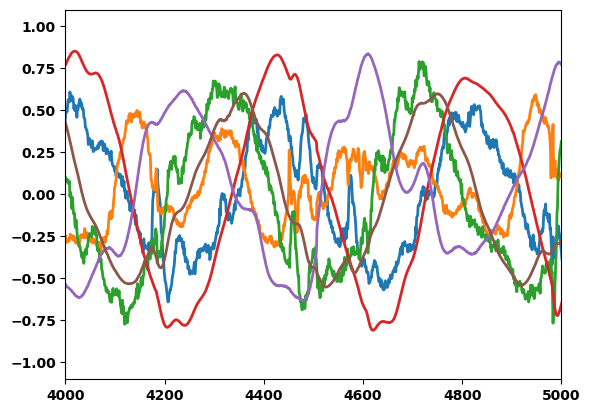

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
for axis in [accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z]:
    axis = axis - axis.mean()
    axis = axis / np.max(np.abs(axis))
    plt.plot(axis, '-', lw=2, label='accel_x')
plt.xlim(4000, 5000)

## Gradient descent

_Based on the explanation given [here](https://frickp.github.io/matrix-gradient-descent.html)._

Let $\mathcal{O}$ be the objective function. 

$$
\rm \mathcal{O} = \frac{1}{2} (\hat{y} - y)^2
$$

Then the gradient of the objective function with respect to the weights is:

$$
\nabla \mathcal{O} = \sum_{i=1}^{n} (\hat{y} - y) \mathcal{D} ( \hat{y} )
$$

where $\mathcal{D}$ is the matrix derivative, defined as follows. 

$$
\mathcal{D} ( \hat{y}_i ) = \begin{bmatrix} \frac{\partial \hat{y}_i}{\partial w_1} \\ \frac{\partial \hat{y}_i}{\partial w_2} \\ \vdots \\ \frac{\partial \hat{y}_i}{\partial w_m} \end{bmatrix}
$$

At each epoch, we will update each weight according to 

$$
w_j = w_j - \alpha \nabla \mathcal{O}
$$

where $\alpha$ is the learning rate.

### Matrix derivative

Consider two matrices $X_{3 \times 2}$ and $W_{2 \times 1}$, and their product $Y_{3 \times 1}$.

$$
X = \begin{bmatrix} x_{1} & x_{4} \\ x_{2} & x_{5} \\ x_{3} & x_{6} \end{bmatrix}
$$
$$
W = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}
$$
$$
Y = XW = 
\begin{bmatrix} 
x_1 w_1 + x_4 w_2 \\ 
x_2 w_1 + x_5 w_2 \\
x_3 w_1 + x_6 w_2
\end{bmatrix}
$$

Then the partial derivative of each weight is 

$$
\frac{\partial Y}{\partial w_1} = 
\begin{bmatrix}
\frac{\partial x_1 w_1 + x_4 w_2}{\partial w_1} \\
\frac{\partial x_2 w_1 + x_5 w_2}{\partial w_1} \\
\frac{\partial x_3 w_1 + x_6 w_2}{\partial w_1}
\end{bmatrix} = 
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
$$

and likewise with $w_2$. This is equivalent to choosing the $j \rm th$ column of $X$ for each weight. 

$$
\frac{\partial XW}{\partial w_1} = 
X \begin{bmatrix} 1 \\ 0 \end{bmatrix} 
$$

and

$$
\frac{\partial XW}{\partial w_2} =
X \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$

The total matrix derivative is 

$$
\mathcal{D} (XW) =
\begin{bmatrix}
x_1 & x_4 \\
x_2 & x_5 \\
x_3 & x_6
\end{bmatrix}
$$

In other words, 

$$
\mathcal{D}\left(f\right)=\left(\begin{array}{cccc}
\partial_{x_{1}}f_{1} & \partial_{x_{2}}f_{1} & \cdots & \partial_{x_{n}}f_{1}\\
\partial_{x_{1}}f_{2} & \partial_{x_{2}}f_{2} & \cdots & \partial_{x_{n}}f_{2}\\
\vdots & \vdots & \ddots & \vdots\\
\partial_{x_{1}}f_{m} & \partial_{x_{2}}f_{m} & \cdots & \partial_{x_{n}}f_{m}
\end{array}\right)
$$

where $f$ is a vector function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$.

### <span style="color:red"> Exercise 1</span>

Generate some test data. In the real lab, this will be done with an accelerometer. The data should be in the form of $y$ and $x,$ both 1D arrays. 

In [5]:
import numpy as np

# Create some matrix x
x = np.array([[1, 2, 3], [4, 5, 6]]).T
w = np.array([1, 1]).T

ones = np.zeros((2,2))
np.fill_diagonal(ones, 1)
np.matmul(x, ones)

array([[1., 4.],
       [2., 5.],
       [3., 6.]])

# QR decomposition for least-squares fitting

We can also fit the data using the QR decomposition.